Set Colab to GPU Mode if you are training the models!

### Mounting Google Drive

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# cd 'drive/MyDrive/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation/'

### Importing Necessary Libraries


In [10]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import os

### Importing Data
We import the data of a young subject's 3D-Tensor Data of dimensions (TR, Voxel, Number of Subjects) for the 5 different ROIs as follows:
- **Prefrontal areas:** dlPFC, vlPFC, lOFC, dmPFC, mPFC, mOFC
- **Default-mode areas:** mPFC, ACC, PCC, Precuneus, mOFC
- **Sensory areas:** VC
- **Multisensory area:** pSTS
- **Some other areas:** TP, IPL, mCC, Put, PCG, Nac, INS





In [11]:
# file_names = [name for name in os.listdir('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy') if name.endswith("npy") and ("(1)" not in name)]
file_names = [name for name in os.listdir('./Data/YOUNG/Voxel_BOLD/Numpy') if name.endswith("npy") and ("(1)" not in name)]
file_names = [name for name in file_names if ("537" not in name)]

In [12]:
ROI_names = [file_name.replace("data_","").replace(".npy","") for file_name in file_names]

In [13]:
data_ori = list()
for file_name in file_names:
    # data_ori.append(np.load('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy/'+file_name))
    data_ori.append(np.load('./Data/YOUNG/Voxel_BOLD/Numpy/'+file_name))

### Data Preparation

Now, here we prepare the data to be fed to the Neural Network Architechtures. Following on the previous developement of the LSTM model to predict BOLD, as a proxy to calculate **Uncertainty**, I use entropy at each time step.

Right from the starting we decide some of the data preparation parameters, so that we can use them as we require.

In [14]:
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 10
LOOK_AHEADS = list(range(1, 2)) 
NUM_TEST_SUBS = 10

We will start a basic data preparation where we will average across all the voxels for a ROI and fit the model which predicts this average BOLD value. Later we will avoid doing an average since, all voxels in a ROI is not equally important and hence we will want to predict the BOLD values of several voxels simultaneously.

In [15]:
data = [np.mean(dat, axis=1, keepdims=True) for dat in data_ori]

Let's Start the Data Preparation for lOFC later we will iterate the same procedure for the other ROIs.

In [16]:
print(ROI_names[-1], "Average BOLD Shape:", data[-1].shape)

TP Average BOLD Shape: (189, 1, 111)


Below, we see the average BOLD time series plot for all the ROIs.

We have changed the data in the form (Number of Subjects, TR, Voxels) below.

In [17]:
data = [np.transpose(dat, (2,0,1)) for dat in data]

In [18]:
print(ROI_names[-1], "Average BOLD Shape:", data[-1].shape)

TP Average BOLD Shape: (111, 189, 1)


In [19]:
# for i in range(len(data)):  
#   plt.figure(figsize=(10, 8))
#   plt.plot(data[i][0,:,0])
#   plt.title("Average BOLD of 1st Subject for "+ROI_names[i])
#   plt.xlabel("TRs")
#   plt.ylabel("Average BOLD(over voxels)")
#   plt.savefig("./Plots/YOUNG/AVG-BOLD/AVG-BOLD-"+ROI_names[i]+".png")

We split the dataset of 111 young subjects into 101 subjects in the training data and 10 subject in the test data.

In [20]:
train_data_unscaled = [dat[:-NUM_TEST_SUBS] for dat in data]
test_data_unscaled = [dat[-NUM_TEST_SUBS:] for dat in data]  

We scaled the BOLD values of each voxel in the train data between 0 and 1 for each voxel. We use the same MinMixScaler fit on the train data on the test data.

In [21]:
scalers = list()
for i in range(len(ROI_names)):
  scalers.append(MinMaxScaler(feature_range = (0, 1)))
train_data = [sc.fit_transform(dat[:,:,0]) for sc, dat in zip(scalers, train_data_unscaled)] 
test_data = [sc.transform(dat[:,:,0]) for sc, dat in zip(scalers, test_data_unscaled)]

In [22]:
train_data = [np.expand_dims(dat, axis = -1) for dat in train_data]
test_data = [np.expand_dims(dat, axis = -1) for dat in test_data]

In [23]:
print(ROI_names[-1], "Train Data Shape: ", train_data[-1].shape)
print(ROI_names[-1], "Test Data Shape: ", test_data[-1].shape)

TP Train Data Shape:  (101, 189, 1)
TP Test Data Shape:  (10, 189, 1)


Now, for the purpose of binning which we will use for calculating entropy, each time point in BOLD signal, after standard scaling needs to be split up into regions based on the value being some standard deviation away from $0$. So, how to split the data is what we will decide here. I go with the split such that each bin contains equal number of values.

In [24]:
NUM_BINS = 30 # Per ROI how many bins should be there

In [25]:
def equalObs(x, nbin):
  nlen = len(x)
  return np.interp(np.linspace(0, nlen, nbin + 1), np.arange(nlen), np.sort(x))

In [26]:
roi_bins = list()
train_target = list()
for roi_data in train_data:
  _, bins, _ = plt.hist(np.squeeze(np.concatenate(roi_data)), equalObs(np.squeeze(np.concatenate(roi_data)), NUM_BINS))
  plt.close()
  roi_bins.append(bins)
  train_target.append(np.sum(roi_data > np.tile(bins, roi_data.shape), axis=-1, keepdims=True))

In [27]:
len(roi_bins[0])

31

Below, we generate the binned plots to see how the results look like for the first subject.

In [28]:
# for i in range(len(data)):  
#   plt.figure(figsize=(10, 8))
#   plt.plot(train_data[i][0,:,0], label='Actual')
#   plt.plot(roi_bins[i][train_target[i][0,:,0]], label='Binned')
#   plt.legend()
#   plt.title("Average BOLD of 1st Subject for "+ROI_names[i]+" with "+str(NUM_BINS)+" binned targets (Train Data Based Bins)")
#   plt.xlabel("TRs")
#   plt.ylabel("Average BOLD(over voxels)[Scaled between 0 and 1]")
#   plt.savefig("./Plots/YOUNG/AVG-BOLD/AVG-BOLD-SCALED-TRAIN-BINNED-"+ROI_names[i]+".png")

Now, from the bins generated from the training data, I will use them to bin the test data

In [29]:
test_target = list()
for roi_data, bins in zip(test_data, roi_bins):
  test_target.append(np.sum(roi_data > np.tile(bins, roi_data.shape), axis=-1, keepdims=True))

We now build a data generator which would produce mini-batches during the training of the neural network.

In [30]:
class KerasBatchGenerator(object):
    def __init__(self, data, bins_data, num_TRs, batch_size, look_ahead=1):
        self.data = data
        self.bins_data = bins_data
        self.num_TRs = num_TRs
        self.batch_size = batch_size
        self.current_idx = 0
        self.look_ahead = look_ahead

    def generate(self):
        while True:
            if self.current_idx + self.batch_size >= self.data.shape[0]:
              self.current_idx = 0
            x = self.data[self.current_idx:(self.current_idx+self.batch_size),:(-self.look_ahead),:]
            y = self.bins_data[self.current_idx:(self.current_idx+self.batch_size),self.look_ahead:,:]
            self.current_idx = self.current_idx + self.batch_size
            yield x, y 

In [31]:
train_data_generator, test_data_generator = list(), list()
for LOOK_AHEAD in LOOK_AHEADS:
    train_data_generator.append([KerasBatchGenerator(dat, bin_dat, dat.shape[1], TRAIN_BATCH_SIZE, LOOK_AHEAD) for dat, bin_dat in zip(train_data, train_target)])
    test_data_generator.append([KerasBatchGenerator(dat, bin_dat, dat.shape[1], TEST_BATCH_SIZE, LOOK_AHEAD) for dat, bin_dat in zip(test_data, test_target)])

In [32]:
batch_xs, batch_ys = list(), list()
for LOOK_AHEAD in LOOK_AHEADS:
    batch = next(train_data_generator[LOOK_AHEAD-1][-1].generate())
    batch_xs.append(batch[0])
    batch_ys.append(batch[1])
    print(f"{ROI_names[-1]} Train Batch X Shape for {LOOK_AHEAD} Ahead: ", batch_xs[LOOK_AHEAD-1].shape)
    print(f"{ROI_names[-1]} Train Batch y Shape for {LOOK_AHEAD} Ahead: ", batch_ys[LOOK_AHEAD-1].shape)

TP Train Batch X Shape for 1 Ahead:  (20, 188, 1)
TP Train Batch y Shape for 1 Ahead:  (20, 188, 1)


In [33]:
batch_xs, batch_ys = list(), list()
for LOOK_AHEAD in LOOK_AHEADS:
    batch = next(test_data_generator[LOOK_AHEAD-1][-1].generate())
    batch_xs.append(batch[0])
    batch_ys.append(batch[1])
    print(f"{ROI_names[-1]} Test Batch X Shape for {LOOK_AHEAD} Ahead: ", batch_xs[LOOK_AHEAD-1].shape)
    print(f"{ROI_names[-1]} Test Batch y Shape for {LOOK_AHEAD} Ahead: ", batch_ys[LOOK_AHEAD-1].shape)

TP Test Batch X Shape for 1 Ahead:  (10, 188, 1)
TP Test Batch y Shape for 1 Ahead:  (10, 188, 1)


### Building Model

We will start off by building a LSTM Model:
- `Number of LSTM Layers = 1`
- `Number of Dense Layers = 2`
- `hidden units = 32`
- `dropout = 0.3`

In [34]:
HIDDEN_UNITS = 32
DROPOUT_PROB = 0.3
LSTM_LAYERS = 1
DENSE_LAYERS = 2

In [35]:
def avg_bold_model():
  model = Sequential()
  for _ in range(LSTM_LAYERS):
    model.add(LSTM(HIDDEN_UNITS, return_sequences=True))
  model.add(Dropout(0.3))
  for _ in range(DENSE_LAYERS-1):
    model.add(TimeDistributed(Dense(HIDDEN_UNITS, activation='relu')))
  model.add(TimeDistributed(Dense(NUM_BINS + 1, activation='softmax')))
  return model

In [36]:
for LOOK_AHEAD in LOOK_AHEADS:
    print(f"***{LOOK_AHEAD} Look Ahead Model***")
    sample_model = avg_bold_model()
    sample_model.build(input_shape=batch_xs[LOOK_AHEAD-1].shape)
    sample_model.summary()

***1 Look Ahead Model***
Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (10, 188, 32)             4352      
                                                                 
 dropout (Dropout)           (10, 188, 32)             0         
                                                                 
 time_distributed (TimeDistr  (10, 188, 32)            1056      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (10, 188, 31)            1023      
 tributed)                                                       
                                                                 
Total params: 6,431
Trainable params: 6,431
Non-trainable params: 0
_____________________________________________________________

2022-11-10 12:19:00.665590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 12:19:00.665719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:
models = [[avg_bold_model() for _ in ROI_names] for _ in LOOK_AHEADS]

#### Training Model

If you haven't already trained the models then uncomment and train your models which will be saved and will be loaded for inference later.

In [38]:
for i in range(len(LOOK_AHEADS)):
    for j in range(len(ROI_names)):
        models[i][j].compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy())

In [39]:
EPOCHS = 300
checkpoint_filepaths = [[f"./Models/YOUNG/LSTM/AVG-BINNED-BOLD/{name}/model_weights-best-val-loss-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{name}" for name in ROI_names] for LOOK_AHEAD in LOOK_AHEADS]
model_checkpoint_callbacks = [[tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepat,
    save_weights_only=True,
    monitor = "val_loss",
    mode='min',
    save_best_only=True) for checkpoint_filepat in checkpoint_filepath] for checkpoint_filepath in checkpoint_filepaths]

In [40]:
def plot_train_test_loss(history, model_name, i):  
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name+' loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig("./Plots/YOUNG/LSTM/AVG-BINNED-BOLD/"+ROI_names[i]+"/"+model_name+"-loss.png")

In [ ]:
histories = list()
with tf.device('/device:GPU:0'):
    for LOOK_AHEAD in LOOK_AHEADS:
        history = list()
        for j in range(len(ROI_names)):
            print(f'***{ROI_names[j]}***')
            hist = models[LOOK_AHEAD-1][j].fit(
                        train_data_generator[LOOK_AHEAD-1][j].generate(),
                        steps_per_epoch=train_data[i].shape[0]//TRAIN_BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=test_data_generator[LOOK_AHEAD-1][j].generate(),
                        validation_steps=test_data[i].shape[0]//TEST_BATCH_SIZE,
                        callbacks=[model_checkpoint_callbacks[LOOK_AHEAD-1][j]]
                        )
            models[LOOK_AHEAD-1][j].save_weights(f"./Models/YOUNG/LSTM/AVG-BINNED-BOLD/{ROI_names[j]}/model_weights-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[j]}")
            plot_train_test_loss(hist, f"{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[j]}", j)
            history.append(hist)
        histories.append(history)

In [106]:
for LOOK_AHEAD in LOOK_AHEADS:
    for i in range(len(ROI_names)):
        models[LOOK_AHEAD-1][i].load_weights(f"./Models/YOUNG/LSTM/AVG-BINNED-BOLD/{ROI_names[i]}/model_weights-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[i]}")

In [80]:
preds_raw = [[models[LOOK_AHEAD-1][i].predict(next(test_data_generator[LOOK_AHEAD-1][i].generate())[0]) for i in range(len(ROI_names))] for LOOK_AHEAD in LOOK_AHEADS]
preds = [[np.argmax(preds_raw[LOOK_AHEAD-1][i], axis=-1) for i in range(len(ROI_names))] for LOOK_AHEAD in LOOK_AHEADS]

1/1 [==============================] - 0s 29ms/step


In [70]:
a_TRs = np.array([56, 67, 73, 81, 134, 142, 155, 167, 174, 180])
d_TRs = np.array([67, 72, 85, 89, 145, 154, 168, 174, 180, 188])
and_TRs = np.union1d(a_TRs, d_TRs)

def highlight_and(act, pred):
  min_y_list = list()
  max_y_list = list()
  for i in range(5):
    min_y_list.append(np.min(np.concatenate([act[a_TRs[2*i]:d_TRs[2*i+1]], pred[a_TRs[2*i]:d_TRs[2*i+1]]])))
    max_y_list.append(np.max(np.concatenate([act[a_TRs[2*i]:d_TRs[2*i+1]], pred[a_TRs[2*i]:d_TRs[2*i+1]]])))
    plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=a_TRs[2*i], x2=d_TRs[2*i+1], color='gray', alpha=0.1)
    plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=a_TRs[2*i], x2=a_TRs[2*i+1], color='violet', alpha=0.4)
    plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=d_TRs[2*i], x2=d_TRs[2*i+1], color='greenyellow', alpha=0.4)

In [71]:
preds[0][-4].shape

(10, 188)

In [ ]:
for LOOK_AHEAD in LOOK_AHEADS:
    for i in range(len(ROI_names)):
      
        actual_test_data_output = np.squeeze(test_target[i])[:,LOOK_AHEAD:] 
        pred_test_data_output = preds[LOOK_AHEAD-1][i]
        plt.figure(figsize=(24, 18))

        for j in range(NUM_TEST_SUBS-1):
  
            ax = plt.subplot(3, 3, j + 1)
            plt.plot(actual_test_data_output[j,:])
            plt.plot(pred_test_data_output[j,:])
            highlight_and(actual_test_data_output[j,:], pred_test_data_output[j,:])
            plt.xticks(np.concatenate([np.array([0]), and_TRs - LOOK_AHEAD]), np.concatenate([np.array([LOOK_AHEAD]), and_TRs]))
            plt.ylabel("Average Binned BOLD")
            plt.xlabel("TRs")
            plt.title(f"Avg Binned BOLD Preds of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead for {j+1}th Test Sub's {ROI_names[i]}")
            plt.legend(['actual', 'pred'])
        plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BINNED-BOLD/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead-Preds.png")

In [78]:
TR_ROI_corr_subs, AVG_TR_ROI_corr_subs = list(), list()
for LOOK_AHEAD in LOOK_AHEADS:
    print(f"***Each Test Subject's Correlation Coefficient between {LOOK_AHEAD} ahead predicted and actual average binned BOLD values for ROIs***")
    print()
    avg_r = list()
    ROI_corr_subs = list()
    for i in range(len(ROI_names)):
        actual_test_data_output = np.squeeze(test_target[i])[:,LOOK_AHEAD:] 
        pred_test_data_output = preds[LOOK_AHEAD-1][i]
        corr_subs = list()
        for j in range(NUM_TEST_SUBS):
            corr_subs.append(np.round(np.corrcoef(actual_test_data_output[j,:], pred_test_data_output[j,:])[0,1], 2))
            print(f"{ROI_names[i]} for {j+1}th sub: {corr_subs[j]}")
        ROI_corr_subs.append(corr_subs)
    TR_ROI_corr_subs.append(ROI_corr_subs)
    print()

    print(f"***Average across test subjects Correlation Coefficient between {LOOK_AHEAD} ahead predicted and actual average binned BOLD values for ROIs***")
    print()
    ROI_corr_subs = list()
    for i in range(len(ROI_names)):
        actual_test_data_output = np.squeeze(test_target[i])[:,LOOK_AHEAD:] 
        pred_test_data_output = preds[LOOK_AHEAD-1][i]
        sum_r = 0
        for j in range(NUM_TEST_SUBS):
            sum_r += np.corrcoef(actual_test_data_output[j,:], pred_test_data_output[j,:])[0,1]
        ROI_corr_subs.append(np.round(sum_r / NUM_TEST_SUBS, 2))
        print(f"{ROI_names[i]}: {ROI_corr_subs[i]}")
    AVG_TR_ROI_corr_subs.append(ROI_corr_subs)

***Each Test Subject's Correlation Coefficient between 1 ahead predicted and actual average binned BOLD values for ROIs***

dlPFC for 1th sub: -0.09
dlPFC for 2th sub: 0.21
dlPFC for 3th sub: 0.07
dlPFC for 4th sub: 0.42
dlPFC for 5th sub: 0.11
dlPFC for 6th sub: 0.11
dlPFC for 7th sub: 0.01
dlPFC for 8th sub: 0.04
dlPFC for 9th sub: 0.15
dlPFC for 10th sub: 0.16
INS for 1th sub: 0.4
INS for 2th sub: 0.6
INS for 3th sub: 0.23
INS for 4th sub: 0.04
INS for 5th sub: -0.14
INS for 6th sub: 0.02
INS for 7th sub: -0.01
INS for 8th sub: 0.08
INS for 9th sub: -0.08
INS for 10th sub: 0.32
VC for 1th sub: -0.01
VC for 2th sub: 0.02
VC for 3th sub: 0.35
VC for 4th sub: 0.05
VC for 5th sub: 0.38
VC for 6th sub: -0.12
VC for 7th sub: 0.18
VC for 8th sub: 0.11
VC for 9th sub: 0.13
VC for 10th sub: 0.13
Cau for 1th sub: -0.02
Cau for 2th sub: 0.26
Cau for 3th sub: 0.06
Cau for 4th sub: 0.07
Cau for 5th sub: 0.06
Cau for 6th sub: -0.01
Cau for 7th sub: nan
Cau for 8th sub: 0.01
Cau for 9th sub: 0.36


/Users/rishideychowdhury/Desktop/Neural-Uncertainty-Representation/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/rishideychowdhury/Desktop/Neural-Uncertainty-Representation/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [79]:
TR_ROI_corr_subs = np.transpose(np.array(TR_ROI_corr_subs), (1,0,2))
AVG_TR_ROI_corr_subs = np.array(AVG_TR_ROI_corr_subs).T
print(TR_ROI_corr_subs.shape, AVG_TR_ROI_corr_subs.shape)

(20, 1, 10) (20, 1)


In [ ]:
# for i in range(len(ROI_names)):
#     plt.figure(figsize=(24, 18))

#     for j in range(NUM_TEST_SUBS-1):

#         ax = plt.subplot(3, 3, j + 1)
#         plt.plot(TR_ROI_corr_subs[i, :, j])
#         plt.xticks(np.arange(1, 16))
#         plt.ylabel("Correlation")
#         plt.xlabel("Ahead TRs")
#         plt.title(f"Avg BOLD Corr of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop for {j+1}th Test Sub's {ROI_names[i]}")
#     plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BOLD-TEST-ENLARGED/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-Upto-15Ahead-Corrs.png")

In [ ]:
# for i in range(len(ROI_names)):
#     plt.figure(figsize=(10, 10))
#     plt.plot(AVG_TR_ROI_corr_subs[i])
#     plt.xticks(np.arange(1, 16))
#     plt.ylabel("Correlation")
#     plt.xlabel("Ahead TRs")
#     plt.title(f"Avg BOLD Corr of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop Across Test Subs")
#     plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BOLD-TEST-ENLARGED/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-Upto-15Ahead-Corrs-Avg-Across-Subs.png")

In [ ]:
# for LOOK_AHEAD in LOOK_AHEADS:
#     print(f"***Model's Final MSE(Train) Loss between {LOOK_AHEAD} ahead predicted and actual average BOLD values for ROIs for the Train Subjects***")
#     print()
#     for i in range(len(ROI_names)):
#         print(ROI_names[i]+":", np.round(histories[LOOK_AHEAD-1][i].history['loss'][-1], 5))
#     print()
#     print(f"***Model's Final MSE(Validation) Loss between {LOOK_AHEAD} ahead predicted and actual average BOLD values for ROIs for the Test Subjects***")
#     print()
#     for i in range(len(ROI_names)):
#         print(ROI_names[i]+":", np.round(histories[LOOK_AHEAD-1][i].history['val_loss'][-1], 5))

In [88]:
CXT_subs, AVG_CXT_subs = list(), list()
for LOOK_AHEAD in LOOK_AHEADS:
    print(f"***Model's Final CXT(Validation) Loss between {LOOK_AHEAD} ahead predicted and actual avg voxel binned BOLD values for ROIs for the Test Subjects***")
    print()
    ROI_CXT_subs, ROI_AVG_CXT_subs = list(), list()
    for i in range(len(ROI_names)):
        actual_test_data_output = np.squeeze(test_target[i])[:,LOOK_AHEAD:] 
        pred_test_data_output = preds_raw[LOOK_AHEAD-1][i]
        ROI_CXT_subs.append(np.mean(tf.keras.losses.sparse_categorical_crossentropy(actual_test_data_output, pred_test_data_output).numpy(), axis=-1))
        print(ROI_names[i]+" for Each Validation Subject:", ROI_CXT_subs[i])
        ROI_AVG_CXT_subs.append(np.mean(ROI_CXT_subs[i]))
        print(ROI_names[i]+" :", ROI_AVG_CXT_subs[i])
    CXT_subs.append(ROI_CXT_subs)
    AVG_CXT_subs.append(ROI_AVG_CXT_subs)

***Model's Final CXT(Validation) Loss between 1 ahead predicted and actual avg voxel binned BOLD values for ROIs for the Test Subjects***

dlPFC for Each Validation Subject: [1.7724779 1.6244137 1.2866542 1.5972774 1.5829418 1.6056178 1.4789046
 1.2217398 2.112343  1.4842166]
dlPFC : 1.5766586
INS for Each Validation Subject: [1.7031778 1.7029176 1.7950126 1.5750405 1.2201107 1.3095689 1.4014758
 1.2021245 1.8132435 1.209784 ]
INS : 1.4932457
VC for Each Validation Subject: [1.4538721 1.4796793 1.4458495 1.7580047 1.6802847 1.6960472 1.7305464
 1.2949632 2.1949472 1.2170968]
VC : 1.595129
Cau for Each Validation Subject: [1.6787765  1.3549117  1.6657348  1.0578653  1.4359754  1.1035438
 1.251939   0.6150127  2.053577   0.99314046]
Cau : 1.3210477
PCC for Each Validation Subject: [1.8051906 1.8509781 2.0584078 1.8148768 1.409853  3.54437   1.9226325
 2.05887   1.9794176 1.8071065]
PCC : 2.0251703
PCG for Each Validation Subject: [1.4565705 1.7729636 1.2557325 1.3135487 1.3259231 1.72175

In [89]:
CXT_subs = np.transpose(np.array(CXT_subs), (1, 0, 2))
AVG_CXT_subs = np.array(AVG_CXT_subs).T
print(CXT_subs.shape, AVG_CXT_subs.shape)

(20, 1, 10) (20, 1)


In [ ]:
# for i in range(len(ROI_names)):
#     plt.figure(figsize=(24, 18))

#     for j in range(NUM_TEST_SUBS-1):

#         ax = plt.subplot(3, 3, j + 1)
#         plt.plot(MSE_subs[i, :, j])
#         plt.xticks(np.arange(1, 16))
#         plt.ylabel("MSE Loss")
#         plt.xlabel("Ahead TRs")
#         plt.title(f"Avg BOLD MSE Losses of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop for {j+1}th Test Sub's {ROI_names[i]}")
#     plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BOLD-TEST-ENLARGED/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-Upto-15Ahead-Losses.png")

In [ ]:
# for i in range(len(ROI_names)):
#     plt.figure(figsize=(10, 10))
#     plt.plot(AVG_MSE_subs[i])
#     plt.xticks(np.arange(1, 16))
#     plt.ylabel("MSE Loss")
#     plt.xlabel("Ahead TRs")
#     plt.title(f"Avg BOLD MSE Losses of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop Across Test Subs")
#     plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BOLD-TEST-ENLARGED/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-Upto-15Ahead-Losses-Avg-Across-Subs.png")

In [ ]:
for LOOK_AHEAD in LOOK_AHEADS:
  for i in range(len(ROI_names)):
    entropy = -1 * np.sum(preds_raw[LOOK_AHEAD-1][i]*np.log(preds_raw[LOOK_AHEAD-1][i]), axis=-1)
    plt.figure(figsize=(24, 18))
    for j in range(NUM_TEST_SUBS-1):
      
      ax = plt.subplot(3, 3, j + 1)
      plt.plot(entropy[j,:])
      highlight_and(entropy[j,:], entropy[j,:])
      plt.xticks(np.concatenate([np.array([0]), and_TRs - LOOK_AHEAD]), np.concatenate([np.array([LOOK_AHEAD]), and_TRs]))
      plt.ylabel("Entropy of preds avg binned BOLD")
      plt.xlabel("TRs")
      plt.title(f"Entropy Avg BOLD of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead for {j+1}th Test Sub's {ROI_names[i]}")
    plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BINNED-BOLD/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead-Preds-Entropy.png")

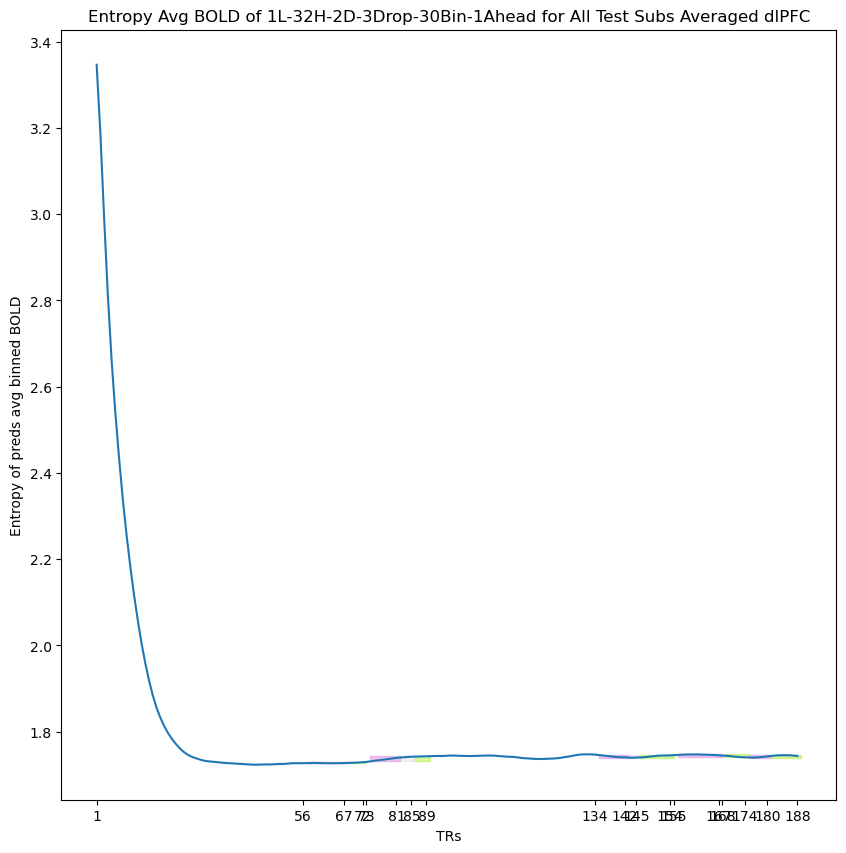

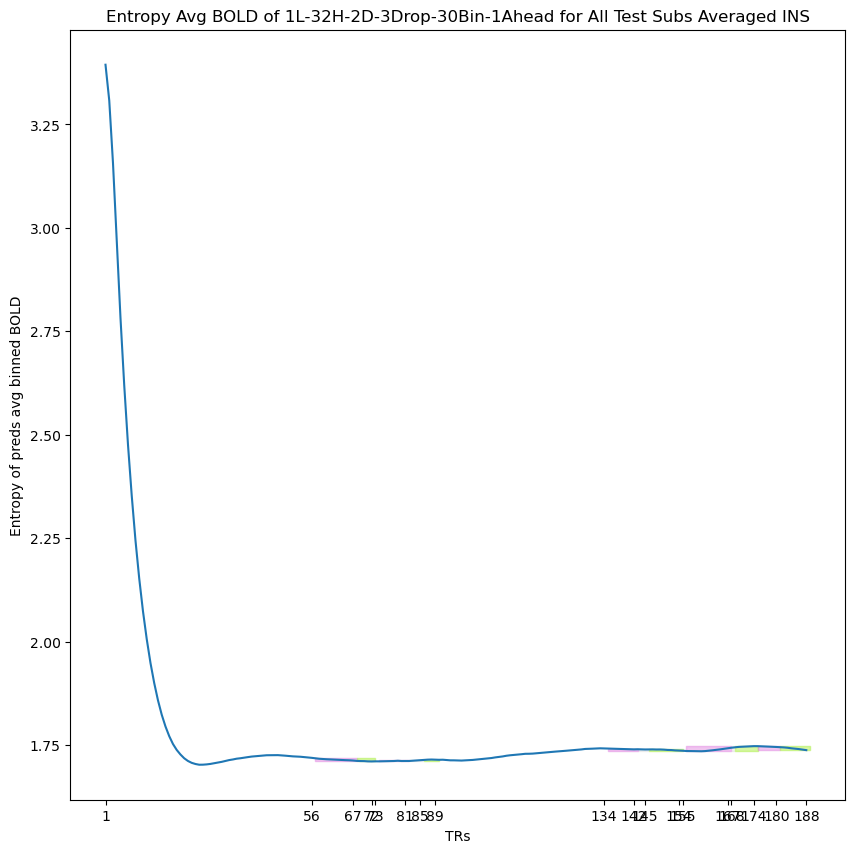

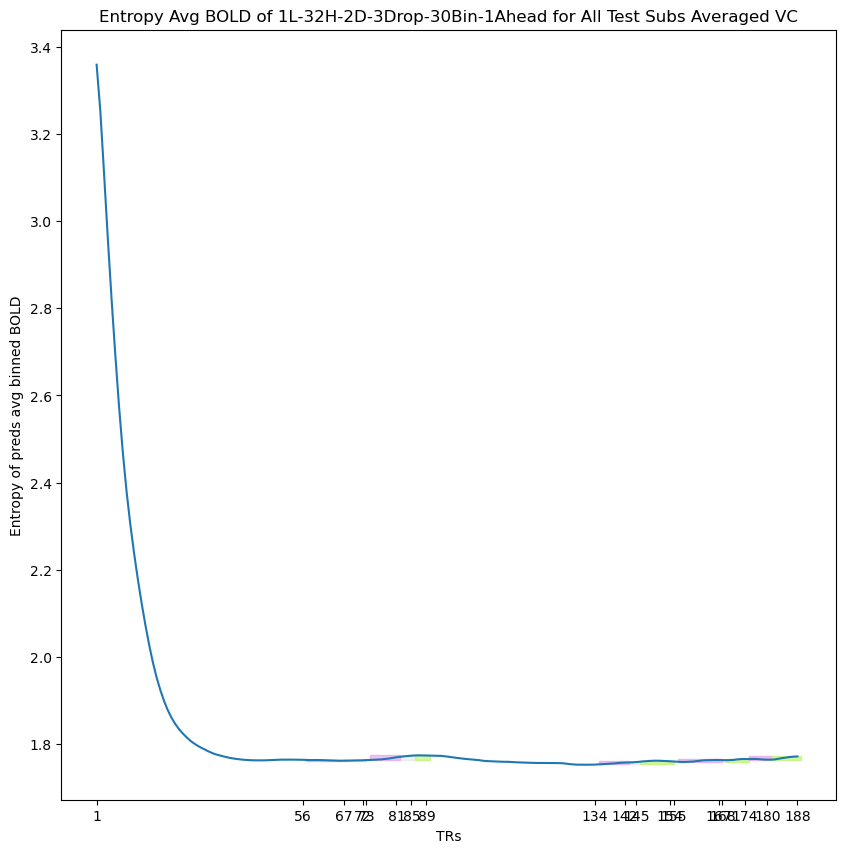

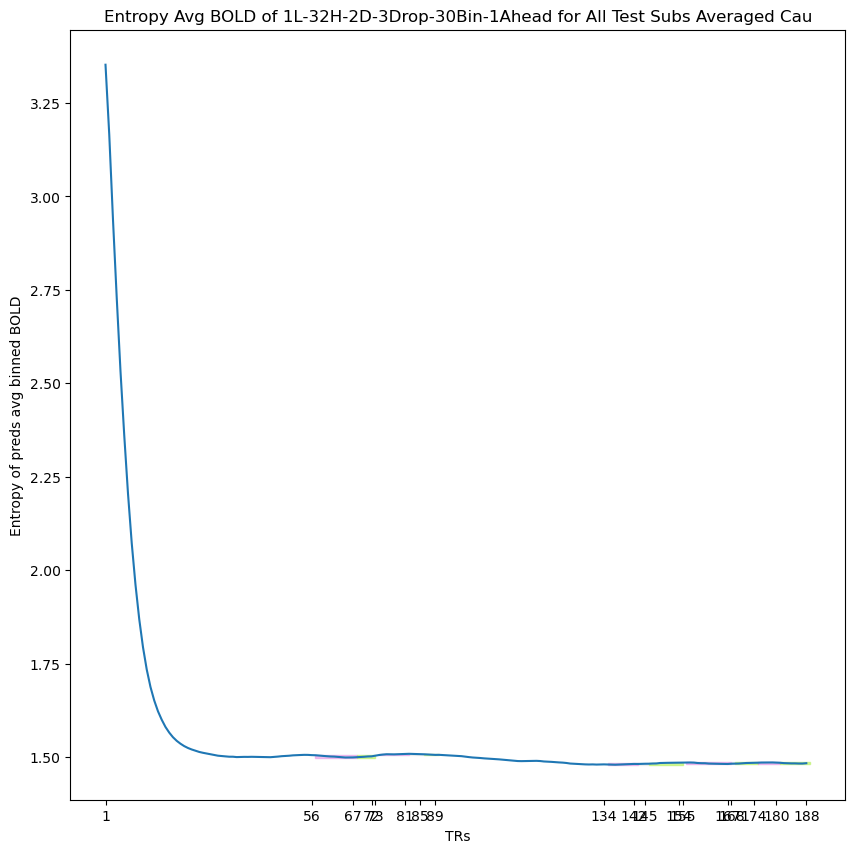

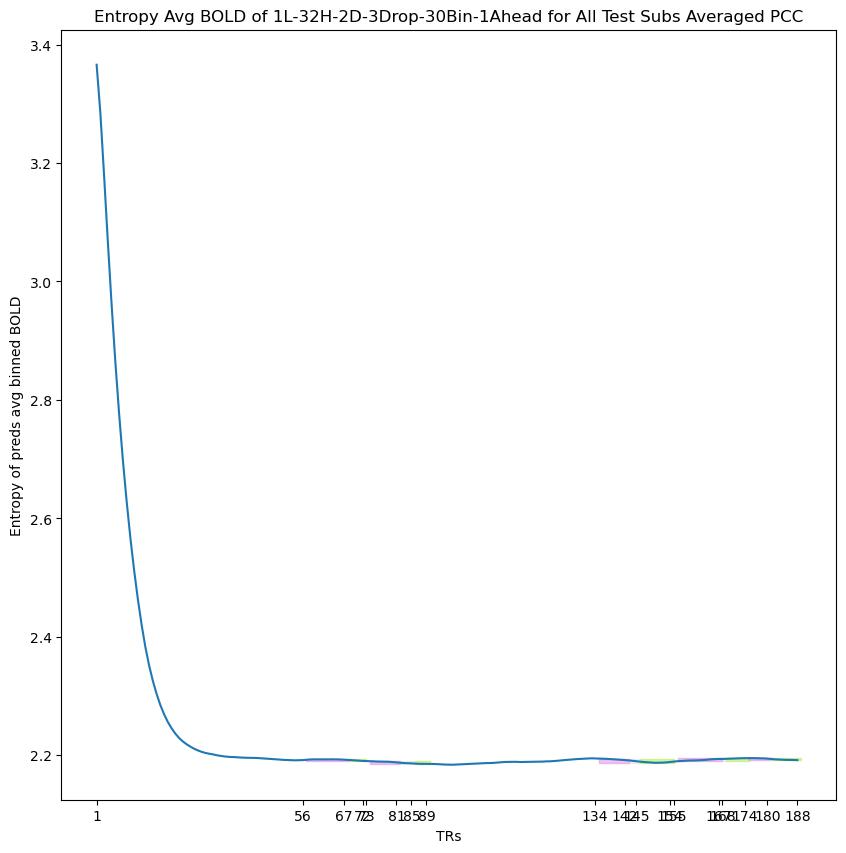

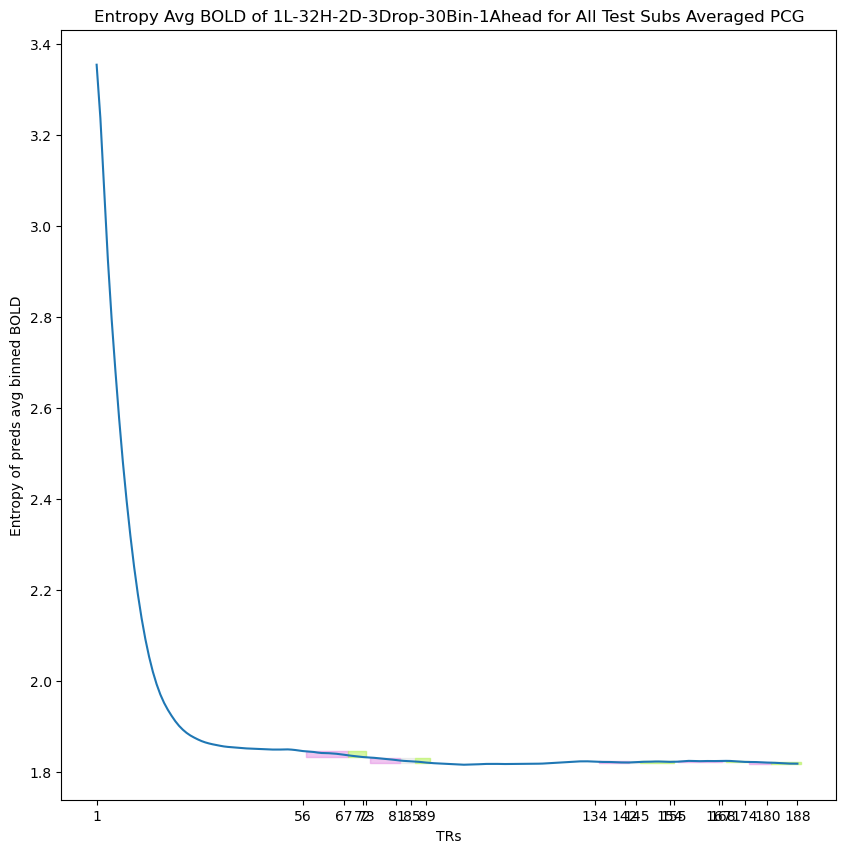

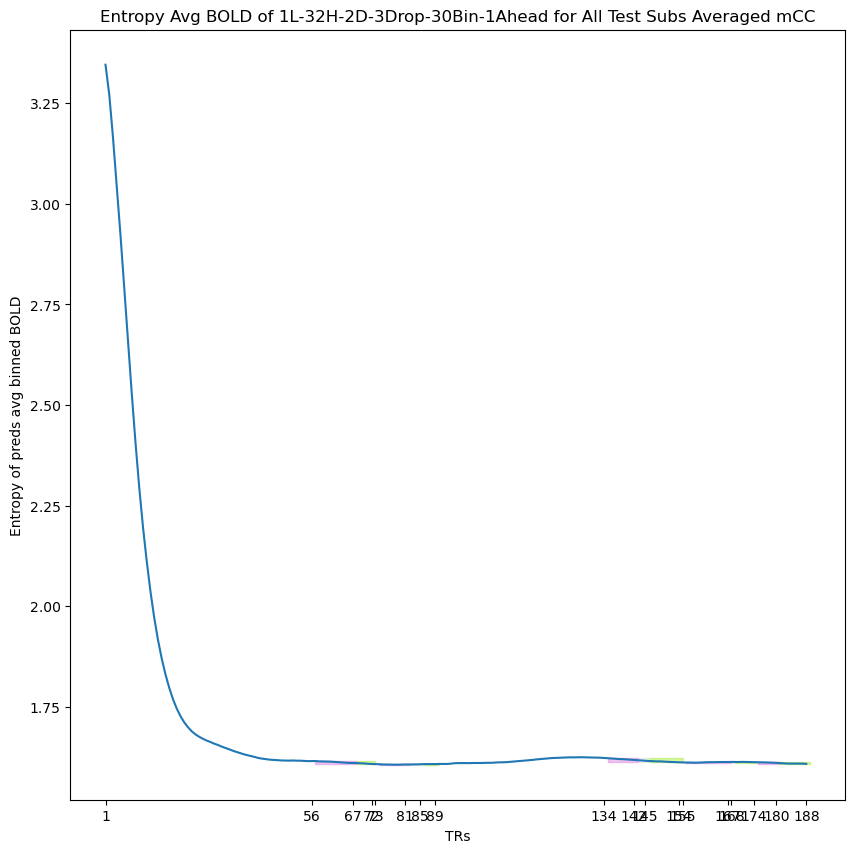

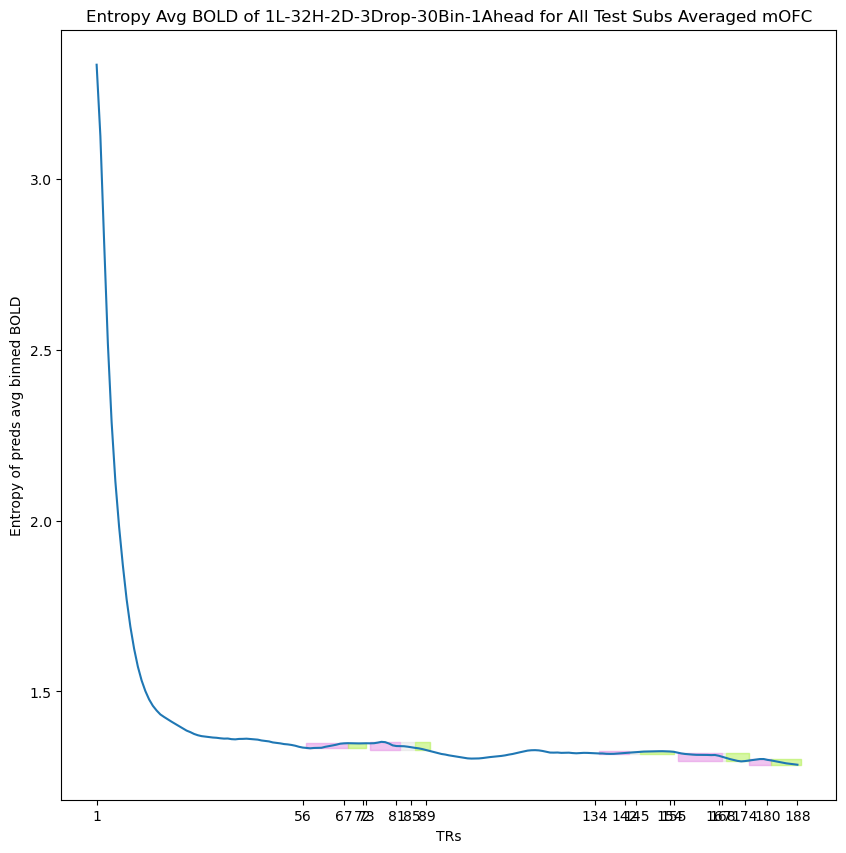

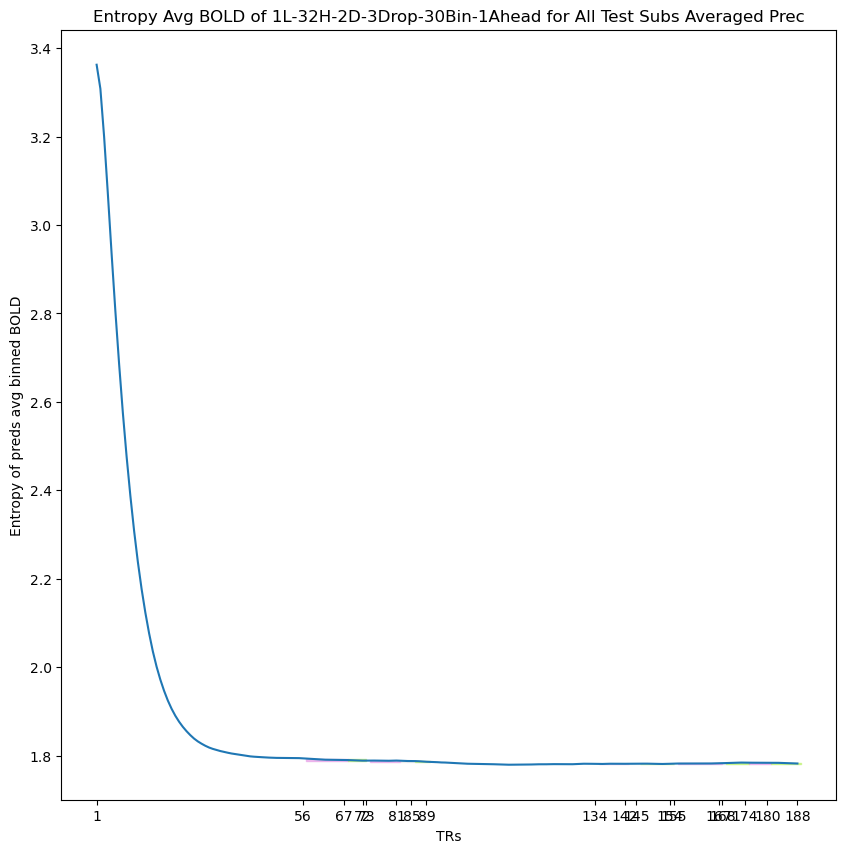

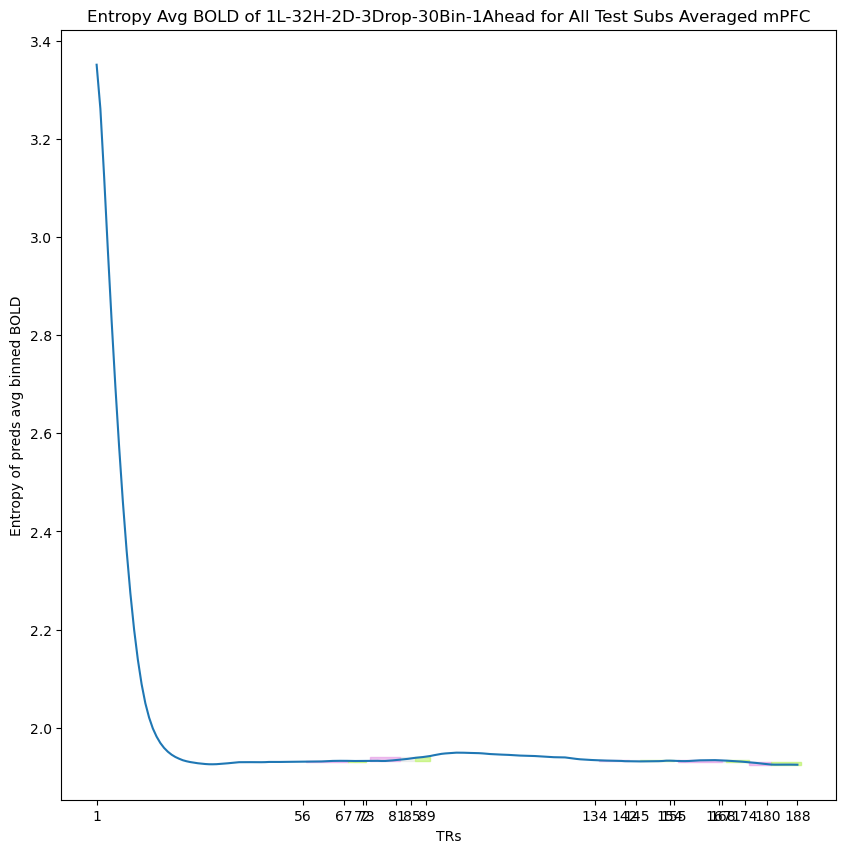

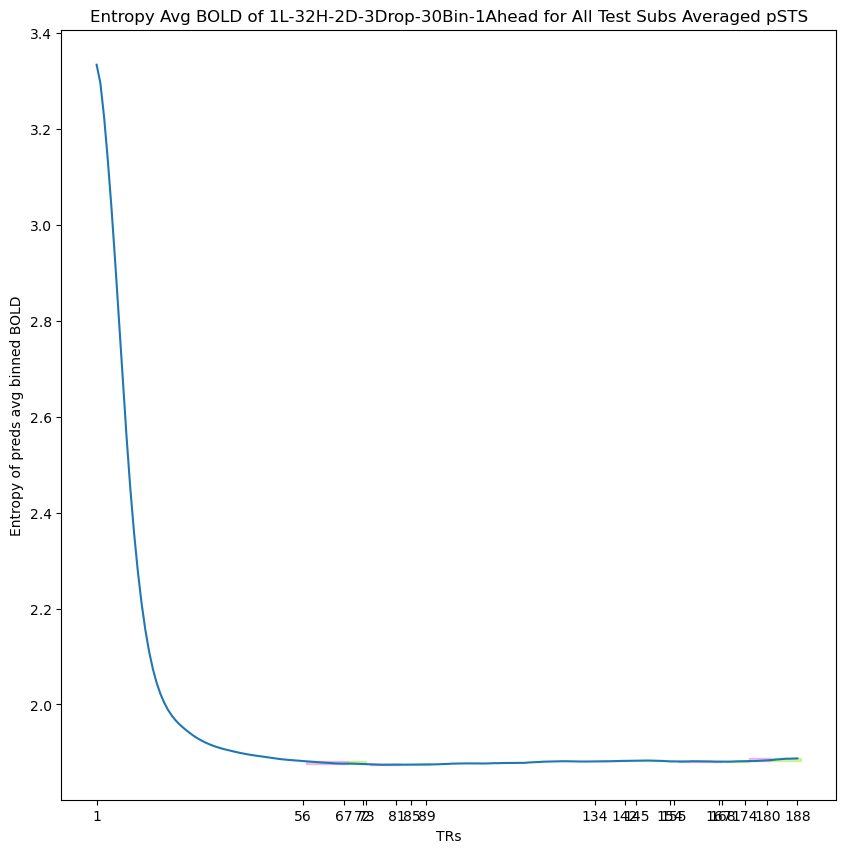

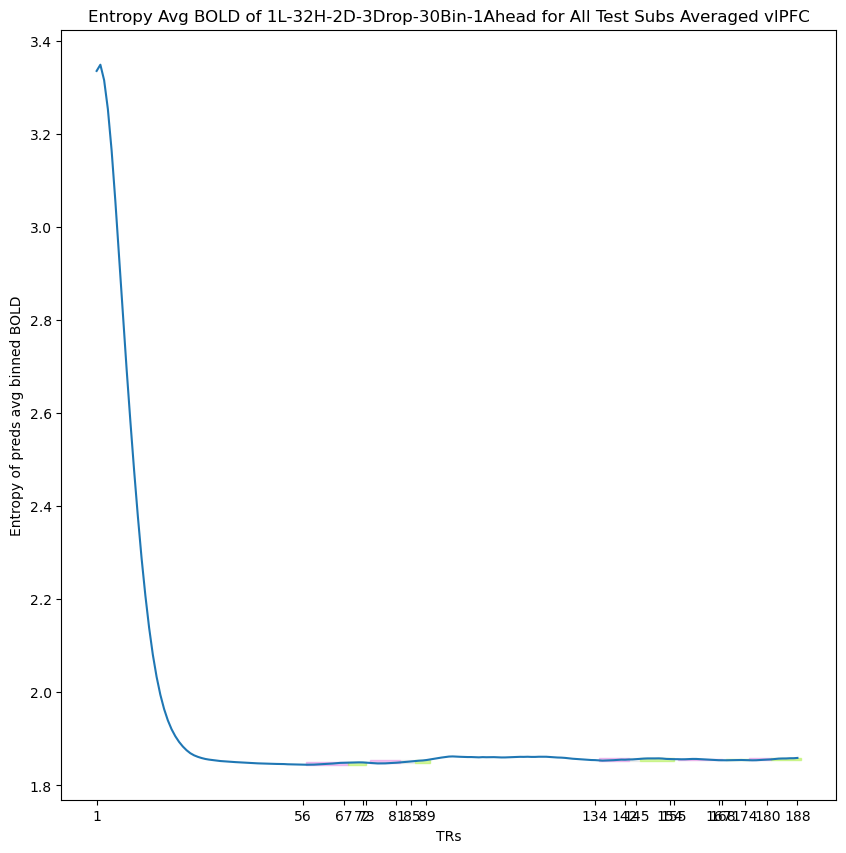

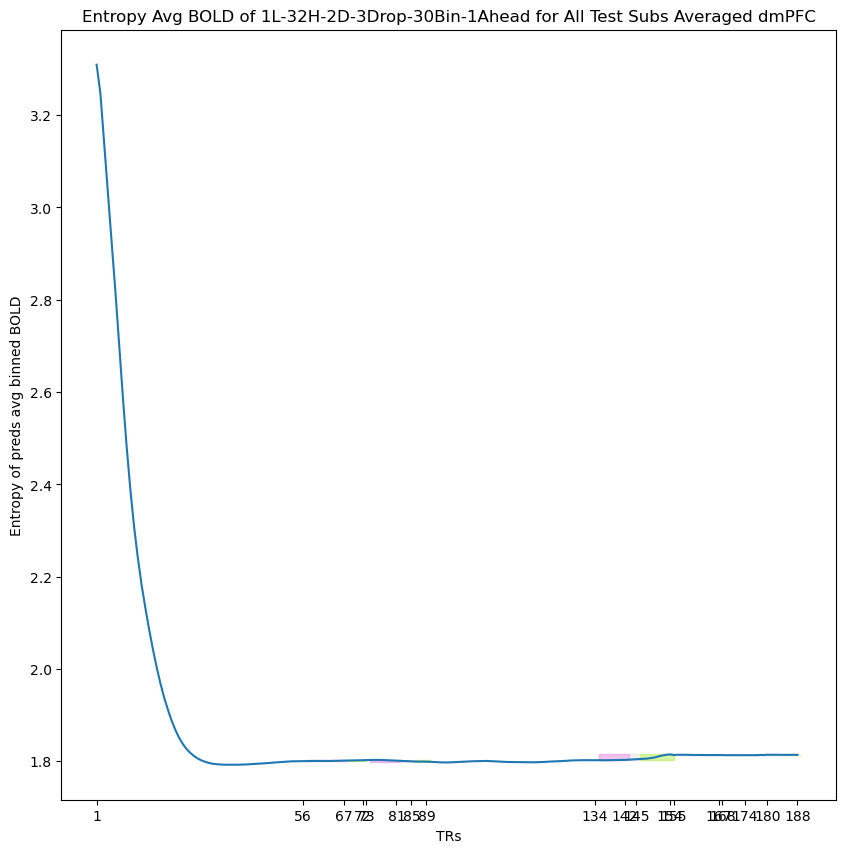

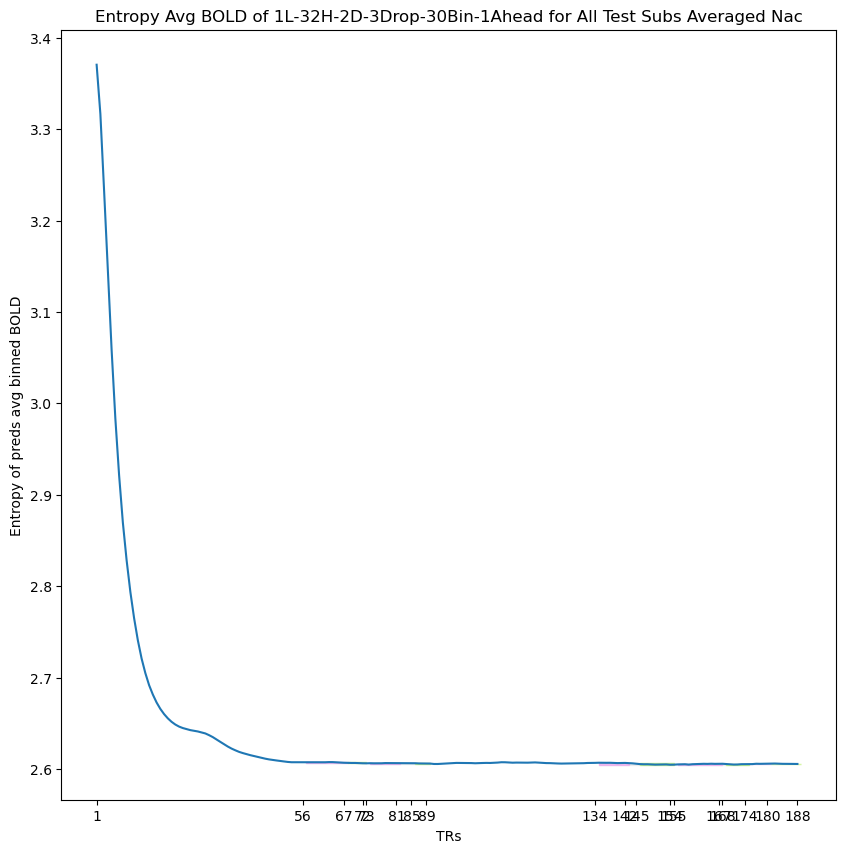

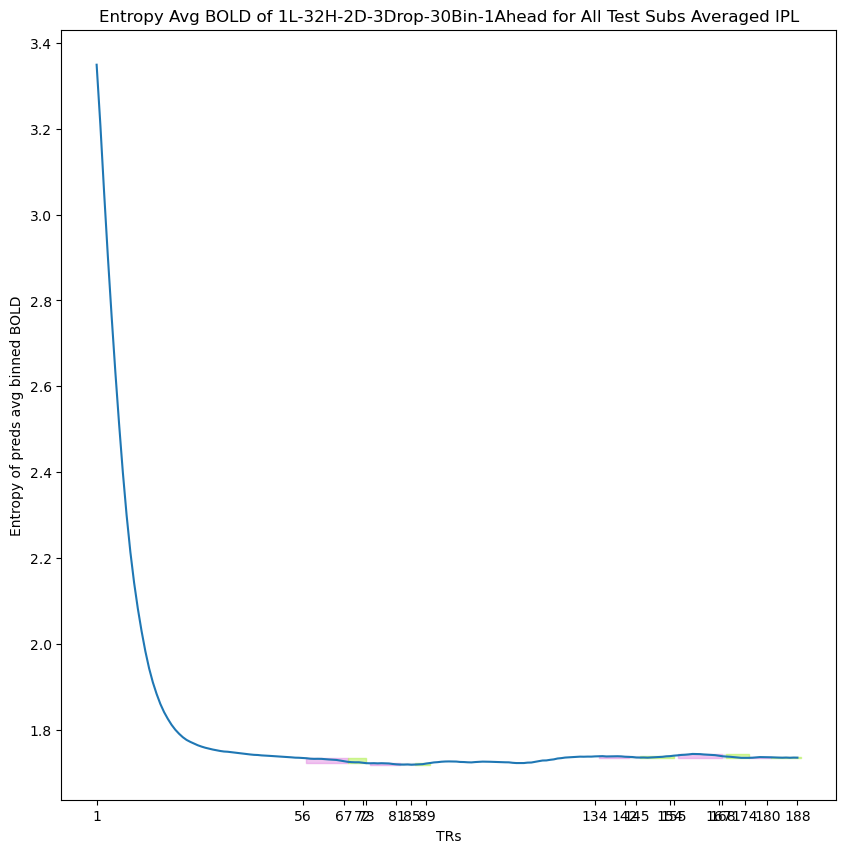

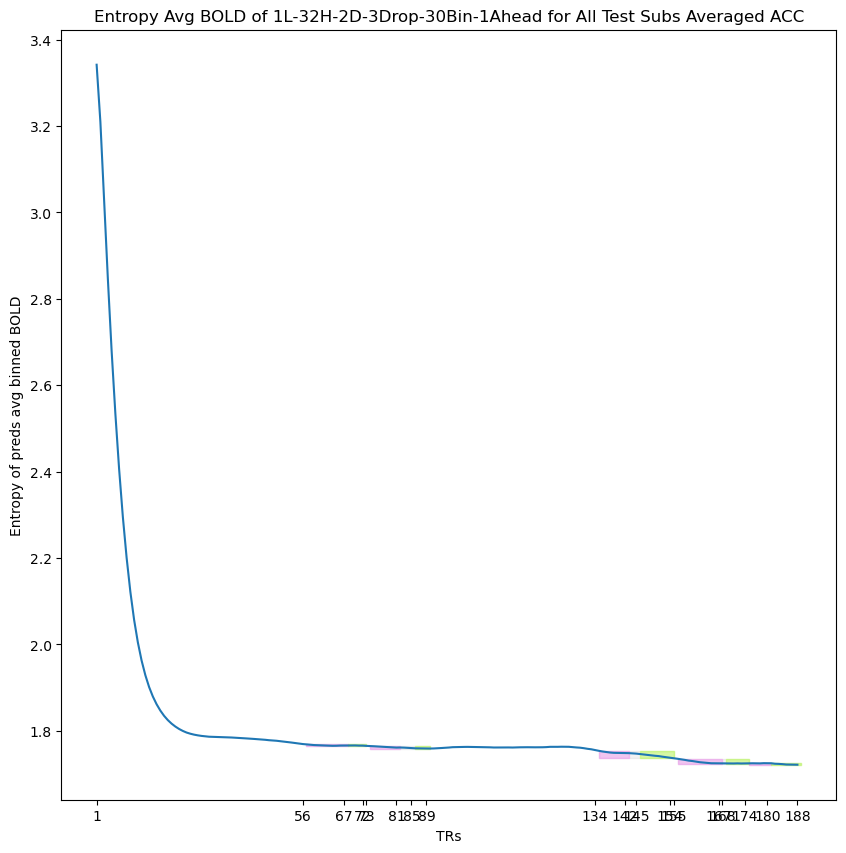

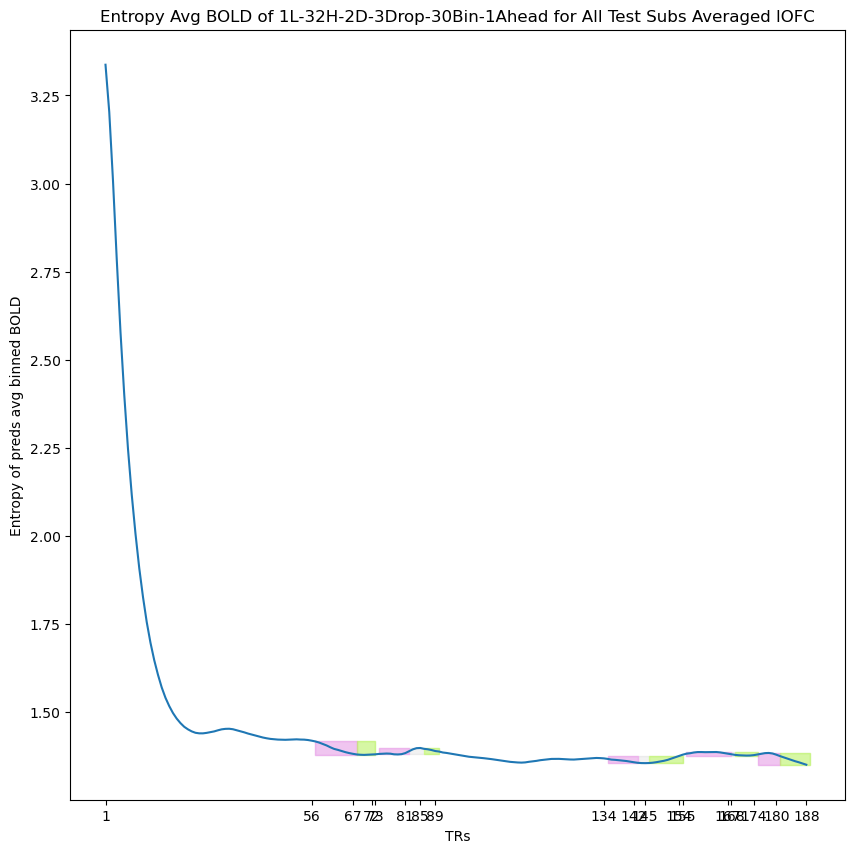

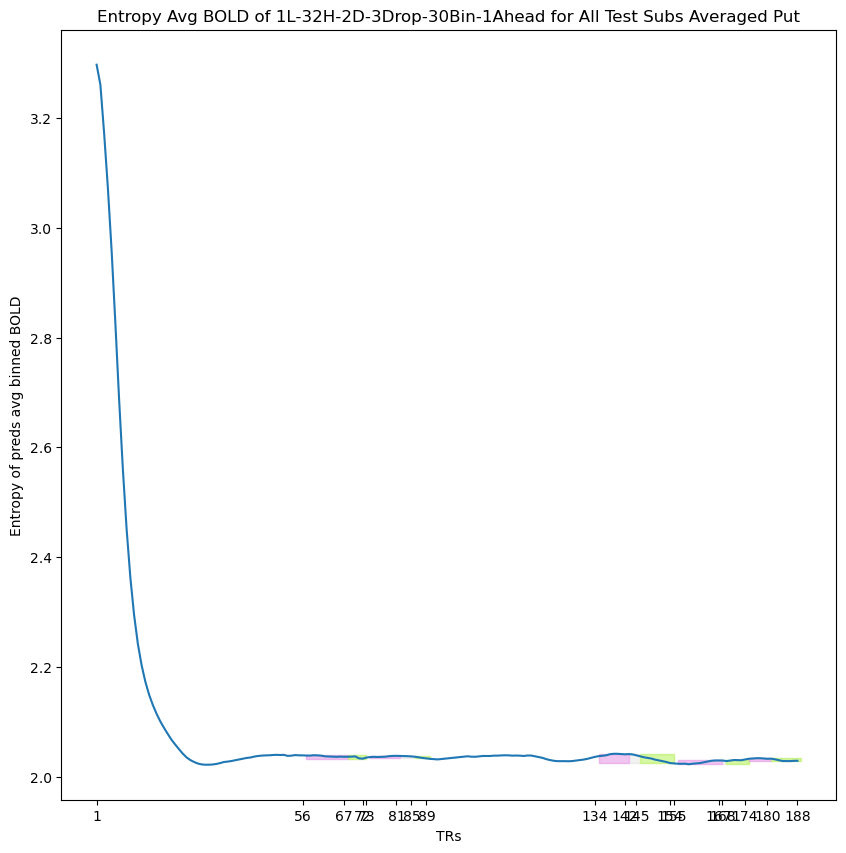

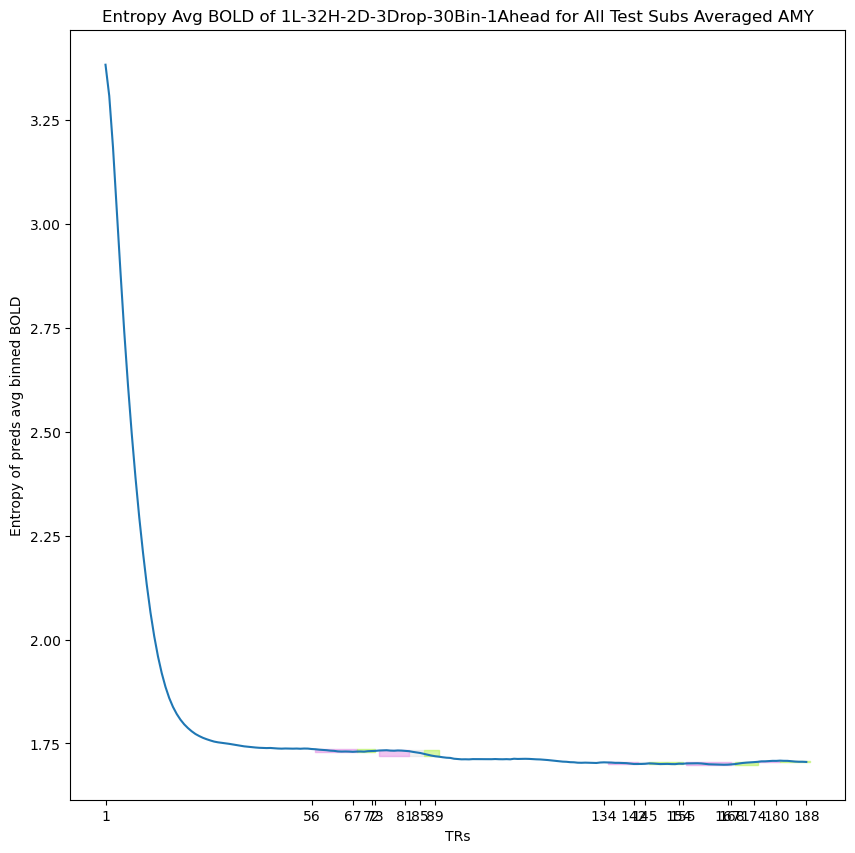

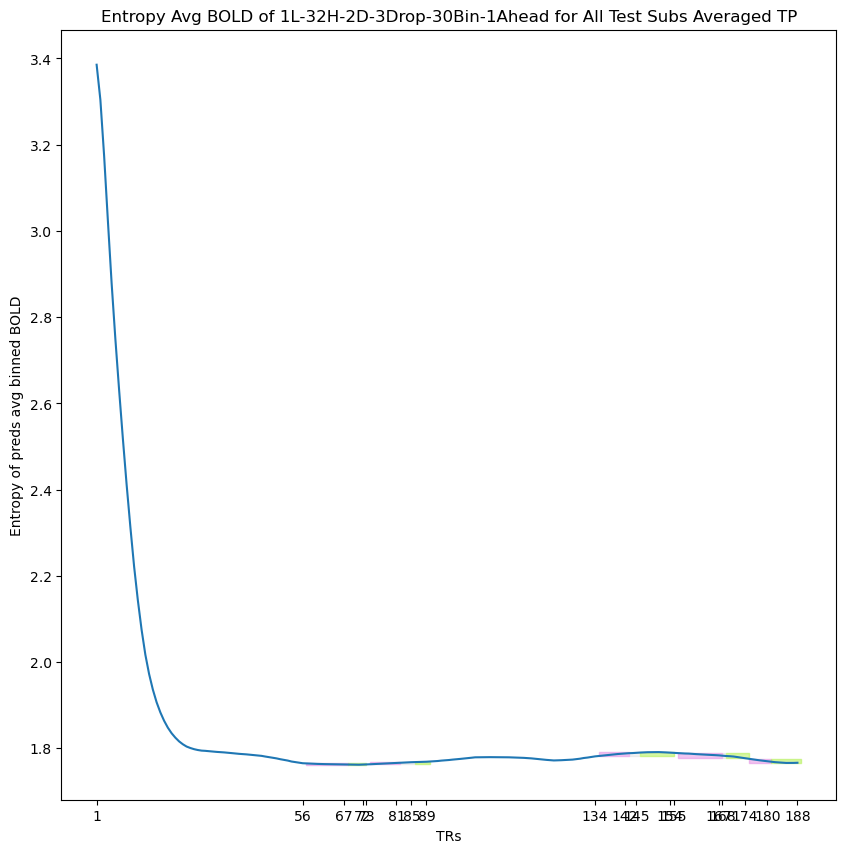

In [110]:
for LOOK_AHEAD in LOOK_AHEADS:
  entropy = [-1 * np.sum(preds_raw[LOOK_AHEAD-1][i]*np.log(preds_raw[LOOK_AHEAD-1][i]), axis=-1) for i in range(len(ROI_names))]
  entropy_avg = [np.mean(entropy_ind, axis=0) for entropy_ind in entropy]
  for i in range(len(ROI_names)):
    plt.figure(figsize=(10, 10))
    plt.plot(entropy_avg[i])
    highlight_and(entropy_avg[i], entropy_avg[i])
    plt.xticks(np.concatenate([np.array([0]), and_TRs - LOOK_AHEAD]), np.concatenate([np.array([LOOK_AHEAD]), and_TRs]))
    plt.ylabel("Entropy of preds avg binned BOLD")
    plt.xlabel("TRs")
    plt.title(f"Entropy Avg BOLD of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead for All Test Subs Averaged {ROI_names[i]}")
    plt.savefig(f"./Plots/YOUNG/LSTM/AVG-BINNED-BOLD/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{NUM_BINS}Bin-{LOOK_AHEAD}Ahead-Preds-All-Averaged-Entropy.png")